In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
import scipy.stats as stats
import numpy as np
from scipy.stats import chi2_contingency

# Import data table and get genotype and glomeruli

In [2]:
df_all = pd.read_csv('../data/screen_all_data.csv', index_col=0).iloc[:,0:50]
df_all

,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VL2p,VM1,VM2,VM3,VM4,VM5d,VM5v,VM6,VM7,genotype
38_left,1,0,0,0,2,0,2,0,2,1,...,0,0,2,2,1,1,1,0,2,WT
38_right,1,0,0,0,2,1,2,0,1,2,...,0,0,2,2,1,2,2,0,2,WT
37_left,0,0,0,0,2,1,1,0,0,0,...,0,0,2,2,0,2,2,0,2,WT
37_right,0,0,0,0,2,1,2,0,0,1,...,0,0,2,2,0,2,2,0,2,WT
36_left,0,0,0,1,2,1,1,0,2,0,...,0,0,2,2,0,1,2,0,2,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37_right,1,0,0,0,2,0,1,0,0,0,...,0,0,2,2,0,2,2,0,2,330060
38_left,0,0,0,0,2,0,2,0,0,0,...,1,0,2,2,0,2,2,2,2,330060
38_right,0,0,1,0,2,0,2,0,0,0,...,1,0,2,2,1,2,2,0,2,330060
39_left,0,0,0,0,2,0,2,0,0,0,...,0,0,2,2,1,2,1,0,2,330060


In [3]:
line_gene = pd.read_csv('../data/line_to_gene.csv', index_col=0, header=None)
line_info = line_gene[2]
line_gene = line_gene[1]
line_gene.index = line_gene.index.astype('str')
line_info.index = line_info.index.astype('str')

In [4]:
glomeruli = df_all.columns[:-1]

In [5]:
def get_glo_freq(df_curr, glomeruli):
    """
    input: dataframe of a current genotype; row: antenna lobe; col: glomeruli names
    output: frequency table of innervation pattern for each glomeruli;
            row: glomeruli names; col: frequency
    """
    freq = pd.DataFrame(columns=np.arange(0,3), index=df_curr.columns)
    for glom in glomeruli:
        curr_freq = np.unique(df_curr[glom], return_counts=True)
        freq.loc[glom][curr_freq[0]] = curr_freq[1]
        
    return freq.fillna(0)

In [6]:
genotype = df_all.genotype.value_counts().index.drop(['30833','2796','12106', '102440','106374'])

In [7]:
df_wt = df_all.loc[df_all['genotype'] == 'WT'].drop('genotype', 1)
freq_wt = get_glo_freq(df_wt, glomeruli)
freq_wt.head()

,0,1,2
D,21,3,0
DA1,24,0,0
DA2,19,5,0
DA3,16,8,0
DA4l,0,0,24


In [8]:
def get_average_score(glo_geno_freq):
    total = glo_geno_freq.sum()
    average = (glo_geno_freq[1] + glo_geno_freq[2]*2)/total
    
    return average

In [9]:
num_line = genotype.shape[0] - 1

In [10]:
chi_square = pd.DataFrame(columns=glomeruli, index=genotype.unique())
for curr_geno in genotype:
    df_curr = df_all.loc[df_all['genotype'] == curr_geno].drop('genotype', 1)
    freq_curr = get_glo_freq(df_curr, glomeruli)  
    for glom in glomeruli:
        c_table = np.array([freq_wt.loc[glom],freq_curr.loc[glom]])
        c_table = c_table[:,(c_table[0] + c_table[1]) != 0]
        p_value = chi2_contingency(c_table)[1] * num_line
        if p_value > 0.05:
            chi_square.loc[curr_geno, glom] = 0
        else:
            mean_wt = get_average_score(freq_wt.loc[glom])
            mean_curr = get_average_score(freq_curr.loc[glom])
            if mean_wt > mean_curr:
                chi_square.loc[curr_geno, glom] = -1
            else:
                chi_square.loc[curr_geno, glom] = 1

In [11]:
chi2_contingency(c_table)[1]

1.0

In [12]:
c_table

array([[24],
       [10]])

In [13]:
chi_square['gene_name'] = line_gene
# chi_square['']
chi_square['gene_name']['WT'] = 'control'
chi_square['gene_name']['piezo'] = 'piezo_mut'
chi_square.tail()

,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VL2p,VM1,VM2,VM3,VM4,VM5d,VM5v,VM6,VM7,gene_name
33979,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ostγ-RNAi
28819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CG32795-RNAi
47811,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,acj6-RNAi
55869,1,0,1,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,-1,0,0,otk-RNAi
330060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dg-RNAi


In [14]:
camp_select = ['#6180ff','#f0f0f0','#f73d34']

In [15]:
chi_square = chi_square.sort_values(by='gene_name')

In [16]:
chi_square['gene_name'] = chi_square['gene_name'].astype('category')

In [17]:
chi_square['line_detail'] = line_info
chi_square['line_detail']['WT'] = 'control'
chi_square['line_detail'] = chi_square['line_detail'].astype('category')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
chi_square

,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VM1,VM2,VM3,VM4,VM5d,VM5v,VM6,VM7,gene_name,line_detail
45436,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,CG16791-RNAi,UAS-CG16791-RNAi (VDRC: 45436)
64015,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,CG16791-RNAi,UAS-CG16791-RNAi (BDSC: 64015)
28819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CG32795-RNAi,UAS-CG32795-RNAi (VDRC: 28819)
109674,0,0,0,0,-1,0,0,0,0,0,...,0,0,-1,0,0,-1,0,-1,CG32795-RNAi,UAS-CG32795-RNAi (VDRC: 109674)
330420,0,0,0,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,CG5027-RNAi,UAS-CG5027-RNAi (VDRC: 330420)
28305,0,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CG5027-RNAi,UAS-CG5027-RNAi (BDSC: 28305)
34895,0,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dg-RNAi,UAS-Dg-RNAi (BDSC: 34895)
330060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dg-RNAi,UAS-Dg-RNAi (VDRC: 330060)
31765,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dop1R1-RNAi,UAS-Dop1R1-RNAi (BDSC: 31765)
55239,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dop1R1-RNAi,UAS-Dop1R1-RNAi (BDSC: 55239)


In [19]:
new_order = ['control', 'acj6-RNAi', 'otk-RNAi','Dop1R1-RNAi', 'Dop2R-RNAi','Ostγ-RNAi','stol-RNAi',
             'Piezo-RNAi', 'CG5027-RNAi','UAS-trn',   # very confident yes
             'Nep3-RNAi','Dg-RNAi','CG32795-RNAi','dpr7-RNAi',# conflicting 
             'dpr15-RNAi', 'CG16791-RNAi',# regular confident
             'mmd-RNAi','TRAM-RNAi', 'UAS-cac1-EGFP','UAS-dally', 'dpr1-RNAi', 'Hasp-RNAi'] # no]

In [20]:
chi_square.gene_name.cat.categories

Index(['CG16791-RNAi', 'CG32795-RNAi', 'CG5027-RNAi', 'Dg-RNAi', 'Dop1R1-RNAi',
       'Dop2R-RNAi', 'Hasp-RNAi', 'Nep3-RNAi', 'Ostγ-RNAi', 'Piezo-RNAi',
       'TRAM-RNAi', 'UAS-cac1-EGFP', 'UAS-dally', 'UAS-trn', 'acj6-RNAi',
       'control', 'dpr1-RNAi', 'dpr15-RNAi', 'dpr7-RNAi', 'mmd-RNAi',
       'otk-RNAi', 'stol-RNAi'],
      dtype='object')

In [21]:
chi_square.gene_name.cat.reorder_categories(new_order, inplace=True)
chi_square.sort_values('gene_name', inplace=True)

In [22]:
trimed = chi_square

In [23]:
chi_square

,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VM1,VM2,VM3,VM4,VM5d,VM5v,VM6,VM7,gene_name,line_detail
WT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,control,control
9827,0,0,0,0,-1,1,-1,0,0,1,...,0,0,0,0,0,0,0,0,acj6-RNAi,UAS-acj6-RNAi (VDRC: 9827)
47811,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,acj6-RNAi,UAS-acj6-RNAi (VDRC: 47811)
105292,0,0,0,0,0,0,-1,0,0,1,...,0,0,0,0,0,-1,0,0,acj6-RNAi,UAS-acj6-RNAi (VDRC: 105292)
55869,1,0,1,0,-1,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,otk-RNAi,UAS-otk-RNAi (BDSC: 55869)
25790,1,0,1,0,-1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,otk-RNAi,UAS-otk-RNAi (BDSC: 25790)
31765,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dop1R1-RNAi,UAS-Dop1R1-RNAi (BDSC: 31765)
55239,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dop1R1-RNAi,UAS-Dop1R1-RNAi (BDSC: 55239)
26001,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,Dop2R-RNAi,UAS-Dop2R-RNAi (BDSC: 26001)
36824,0,0,1,0,-1,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,Dop2R-RNAi,UAS-Dop2R-RNAi (BDSC: 36824)


In [25]:
not_confident = ['DL4','DM5','VA5','VC4','VM1','VM3','VM7','DL2v','DL2d','VM4',"DL1"]

In [26]:
df_chiSquare_gene = trimed.set_index('gene_name').drop(not_confident, axis=1)

In [28]:
glo_order = ['DA4m', 'DC4', 'D', 'V', 'DA2', 'VA7m', 'VA1d',
             'DP1l', 'VA1v', 'DA1', 'DC3', 'VA4', 'VL1', 'DM1', 'VM6', 'DM2', 'VL2p', 
             'DA3', 'DC2', 'DL3', 'VC1', 'VC2', 'VC3', 'VM2', 'VM5d',
             'DM4', 'VA3', 'VA7l', 'VL2a', 'DC1', 'VM5v', 'DA4l',
             'DL5',  'DM6', 'VA6', 'VA2', 'DM3', 'DP1m']

Text(50.999999999999986, 0.5, '')

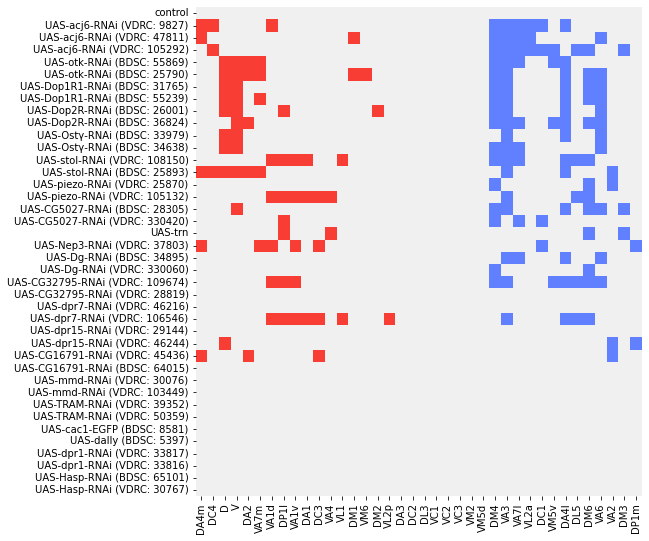

In [29]:
f, ax = plt.subplots(figsize=(8, 9))
ax = sns.heatmap(df_chiSquare_gene[glo_order], cmap=camp_select, cbar=False)
plt.ylabel('')
# plt.savefig("../figure/chi_square/adjusted_ordered.png", bbox_inches = 'tight',dpi=600)

# plot bargraph

In [30]:
df_all_info = df_all.set_index('genotype')
df_all_info.tail()

,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VL2a,VL2p,VM1,VM2,VM3,VM4,VM5d,VM5v,VM6,VM7
genotype,,,,,,,,,,,,,,,,,,,,,
330060,1,0,0,0,2,0,1,0,0,0,...,2,0,0,2,2,0,2,2,0,2
330060,0,0,0,0,2,0,2,0,0,0,...,2,1,0,2,2,0,2,2,2,2
330060,0,0,1,0,2,0,2,0,0,0,...,2,1,0,2,2,1,2,2,0,2
330060,0,0,0,0,2,0,2,0,0,0,...,2,0,0,2,2,1,2,1,0,2
330060,0,0,0,0,2,0,2,0,0,1,...,2,0,0,2,2,0,1,1,2,2


In [31]:
df_all_info['line_detail'] = line_info
df_all_info['line_detail']['WT'] = 'control'
df_all_info

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VL2p,VM1,VM2,VM3,VM4,VM5d,VM5v,VM6,VM7,line_detail
genotype,,,,,,,,,,,,,,,,,,,,,
WT,1,0,0,0,2,0,2,0,2,1,...,0,0,2,2,1,1,1,0,2,control
WT,1,0,0,0,2,1,2,0,1,2,...,0,0,2,2,1,2,2,0,2,control
WT,0,0,0,0,2,1,1,0,0,0,...,0,0,2,2,0,2,2,0,2,control
WT,0,0,0,0,2,1,2,0,0,1,...,0,0,2,2,0,2,2,0,2,control
WT,0,0,0,1,2,1,1,0,2,0,...,0,0,2,2,0,1,2,0,2,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330060,1,0,0,0,2,0,1,0,0,0,...,0,0,2,2,0,2,2,0,2,UAS-Dg-RNAi (VDRC: 330060)
330060,0,0,0,0,2,0,2,0,0,0,...,1,0,2,2,0,2,2,2,2,UAS-Dg-RNAi (VDRC: 330060)
330060,0,0,1,0,2,0,2,0,0,0,...,1,0,2,2,1,2,2,0,2,UAS-Dg-RNAi (VDRC: 330060)


In [33]:
df_chiSquare_gene

,D,DA1,DA2,DA3,DA4l,DA4m,DC1,DC2,DC3,DC4,...,VC1,VC2,VC3,VL1,VL2a,VL2p,VM2,VM5d,VM5v,VM6
line_detail,,,,,,,,,,,,,,,,,,,,,
control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UAS-acj6-RNAi (VDRC: 9827),0,0,0,0,-1,1,-1,0,0,1,...,0,0,0,0,-1,0,0,0,0,0
UAS-acj6-RNAi (VDRC: 47811),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-1,0,0,0,0,0
UAS-acj6-RNAi (VDRC: 105292),0,0,0,0,0,0,-1,0,0,1,...,0,0,0,0,-1,0,0,0,-1,0
UAS-otk-RNAi (BDSC: 55869),1,0,1,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,0
UAS-otk-RNAi (BDSC: 25790),1,0,1,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
UAS-Dop1R1-RNAi (BDSC: 31765),1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UAS-Dop1R1-RNAi (BDSC: 55239),1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UAS-Dop2R-RNAi (BDSC: 26001),1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
pd_freq = pd.DataFrame(columns=['genotype','glomerulus','none','weak','strong','total'])
for curr_geno in df_chiSquare_gene['line_detail']:
    for curr_glo in glo_order:
        counts = df_all_info[df_all_info.line_detail == curr_geno][curr_glo].value_counts().sort_index()
        if 0 not in counts:
            none = 0
        else:
            none = counts[0]
        if 1 not in counts:
            weak = 0
        else:
            weak = counts[1]
        if 2 not in counts:
            strong = 0
        else:
            strong = counts[2]         
        pd_freq = pd_freq.append({'genotype':curr_geno, 'glomerulus':curr_glo,'none':none,
                                  'weak':weak,'strong':strong,'total':none+weak+strong},ignore_index=True)

KeyError: 'line_detail'

In [39]:
pd_freq['genotype'] = pd_freq['genotype'].astype('category')
pd_freq.genotype.cat.reorder_categories(chi_square.line_detail.cat.categories, inplace=True)
pd_freq.sort_values('genotype', inplace=True)

In [40]:
def get_glo_freq_percent(glomerulus, genotype, pd_freq):
    pd_curr = pd_freq[(pd_freq['glomerulus'] == glomerulus) & (pd_freq['genotype'].isin(genotype))]
    pd_glo_freq = pd.DataFrame({'genotype':pd_curr['genotype'],
                                'none':pd_curr['none']/pd_curr['total']*100,
                                'weak':pd_curr['weak']/pd_curr['total']*100,
                                'strong':pd_curr['strong']/pd_curr['total']*100})
    return pd_glo_freq

In [41]:
genotype = df_chiSquare_gene.line_detail.tolist()

In [42]:
glomerulus = 'VA6'
plot_freq = get_glo_freq_percent(glomerulus,genotype, pd_freq)
plot_freq.head()

,genotype,none,weak,strong
1136,UAS-CG16791-RNAi (BDSC: 64015),0,9.52381,90.4762
1098,UAS-CG16791-RNAi (VDRC: 45436),0,0,100
908,UAS-CG32795-RNAi (VDRC: 109674),0,55,45
870,UAS-CG32795-RNAi (VDRC: 28819),0,6.25,93.75
642,UAS-CG5027-RNAi (BDSC: 28305),11.7647,70.5882,17.6471


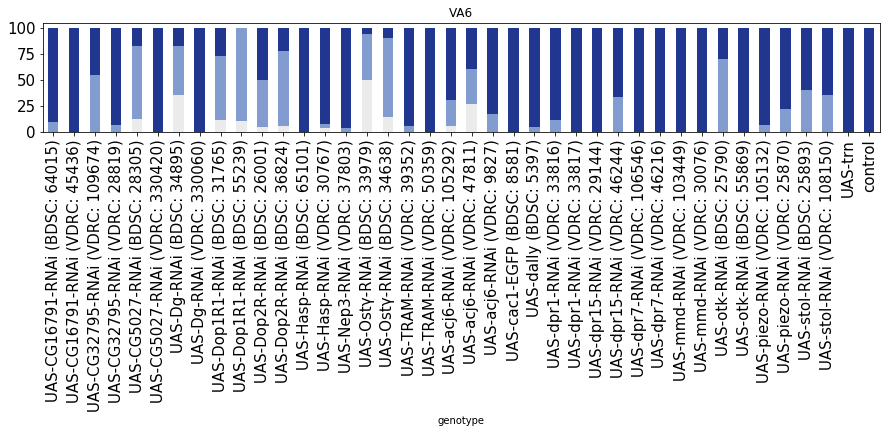

In [43]:
ax = plot_freq.plot(x = 'genotype', kind = 'bar', stacked = True, 
                    color={"none": "#EBEBEB", "weak": "#829CD0",'strong':'#20368F'},
                    title = glomerulus, fontsize=15, legend=False, figsize=(15, 2)) 

In [44]:
plot_freq

,genotype,none,weak,strong
1136,UAS-CG16791-RNAi (BDSC: 64015),0,9.52381,90.4762
1098,UAS-CG16791-RNAi (VDRC: 45436),0,0,100
908,UAS-CG32795-RNAi (VDRC: 109674),0,55,45
870,UAS-CG32795-RNAi (VDRC: 28819),0,6.25,93.75
642,UAS-CG5027-RNAi (BDSC: 28305),11.7647,70.5882,17.6471
680,UAS-CG5027-RNAi (VDRC: 330420),0,0,100
794,UAS-Dg-RNAi (BDSC: 34895),35.2941,47.0588,17.6471
832,UAS-Dg-RNAi (VDRC: 330060),0,0,100
262,UAS-Dop1R1-RNAi (BDSC: 31765),11.5385,61.5385,26.9231
300,UAS-Dop1R1-RNAi (BDSC: 55239),10,90,0


In [45]:
def plot_bars(pd_freq, all_glomeruli):
    fig, axes = plt.subplots(len(all_glomeruli), 1, figsize=(15,2*len(all_glomeruli)), sharex=True)
    i = 0
    for glomerulus in all_glomeruli:
        plot_freq = get_glo_freq_percent(glomerulus, genotype, pd_freq)
        plot_freq.plot(x = 'genotype', kind = 'bar', stacked = True, ax=axes[i],
                            color={"none": "#EBEBEB", "weak": "#829CD0",'strong':'#20368F'},
                            fontsize=15, legend=False)
        axes[i].set_xlabel('')
        axes[i].set_xticklabels(genotype)
        axes[i].set_title('')
        axes[i].set_ylabel(glomerulus, fontsize=18)
        i += 1
    return fig, axes

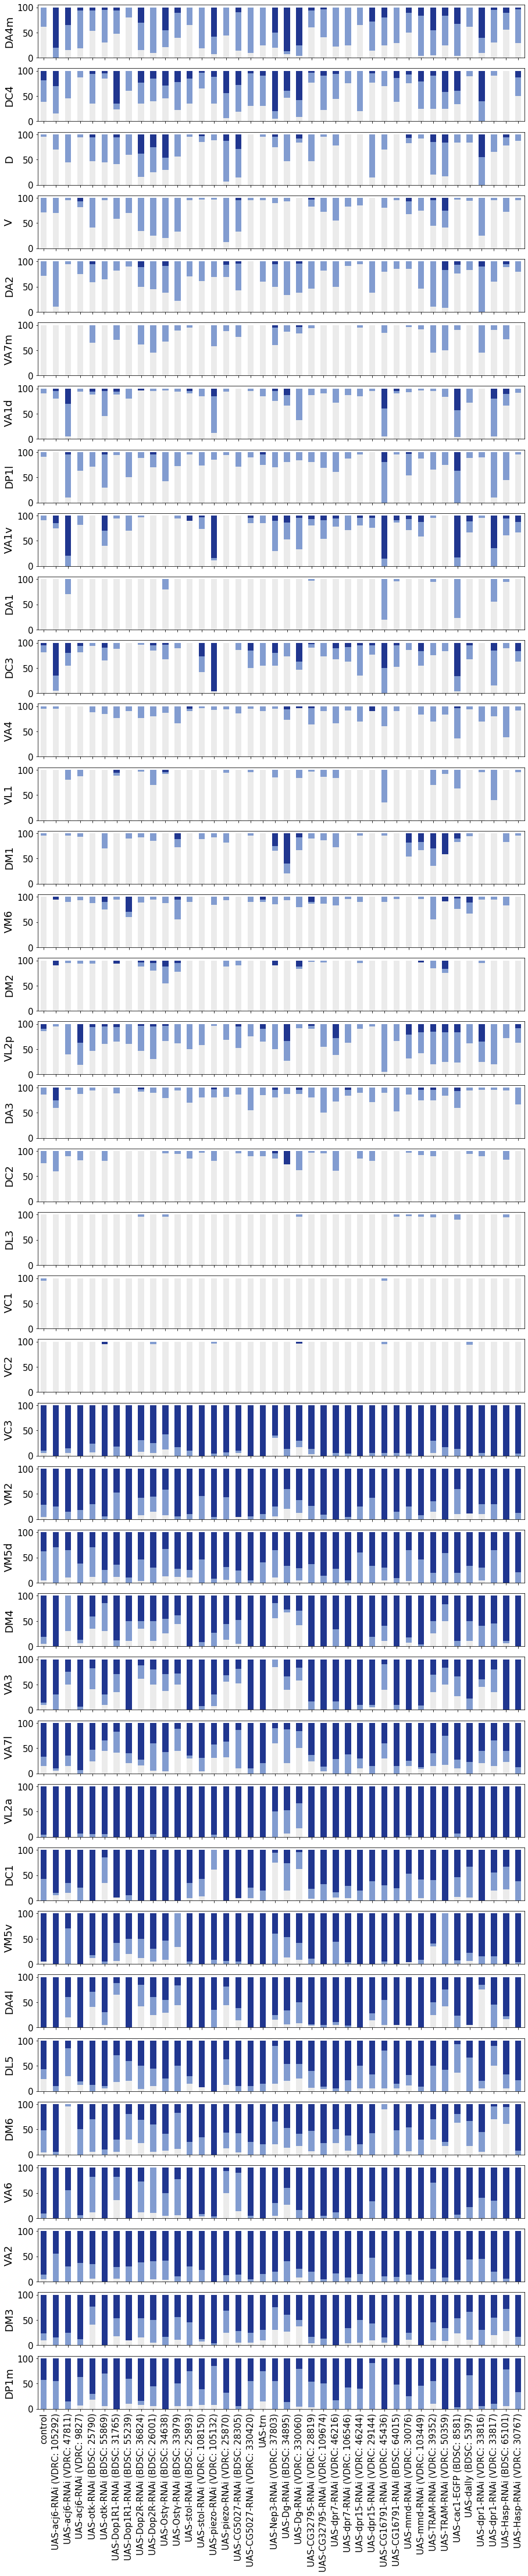

In [46]:
fig, axes = plot_bars(pd_freq, glo_order)
fig.savefig('../figure/stacked_bar/gene_name.pdf', bbox_inches='tight')

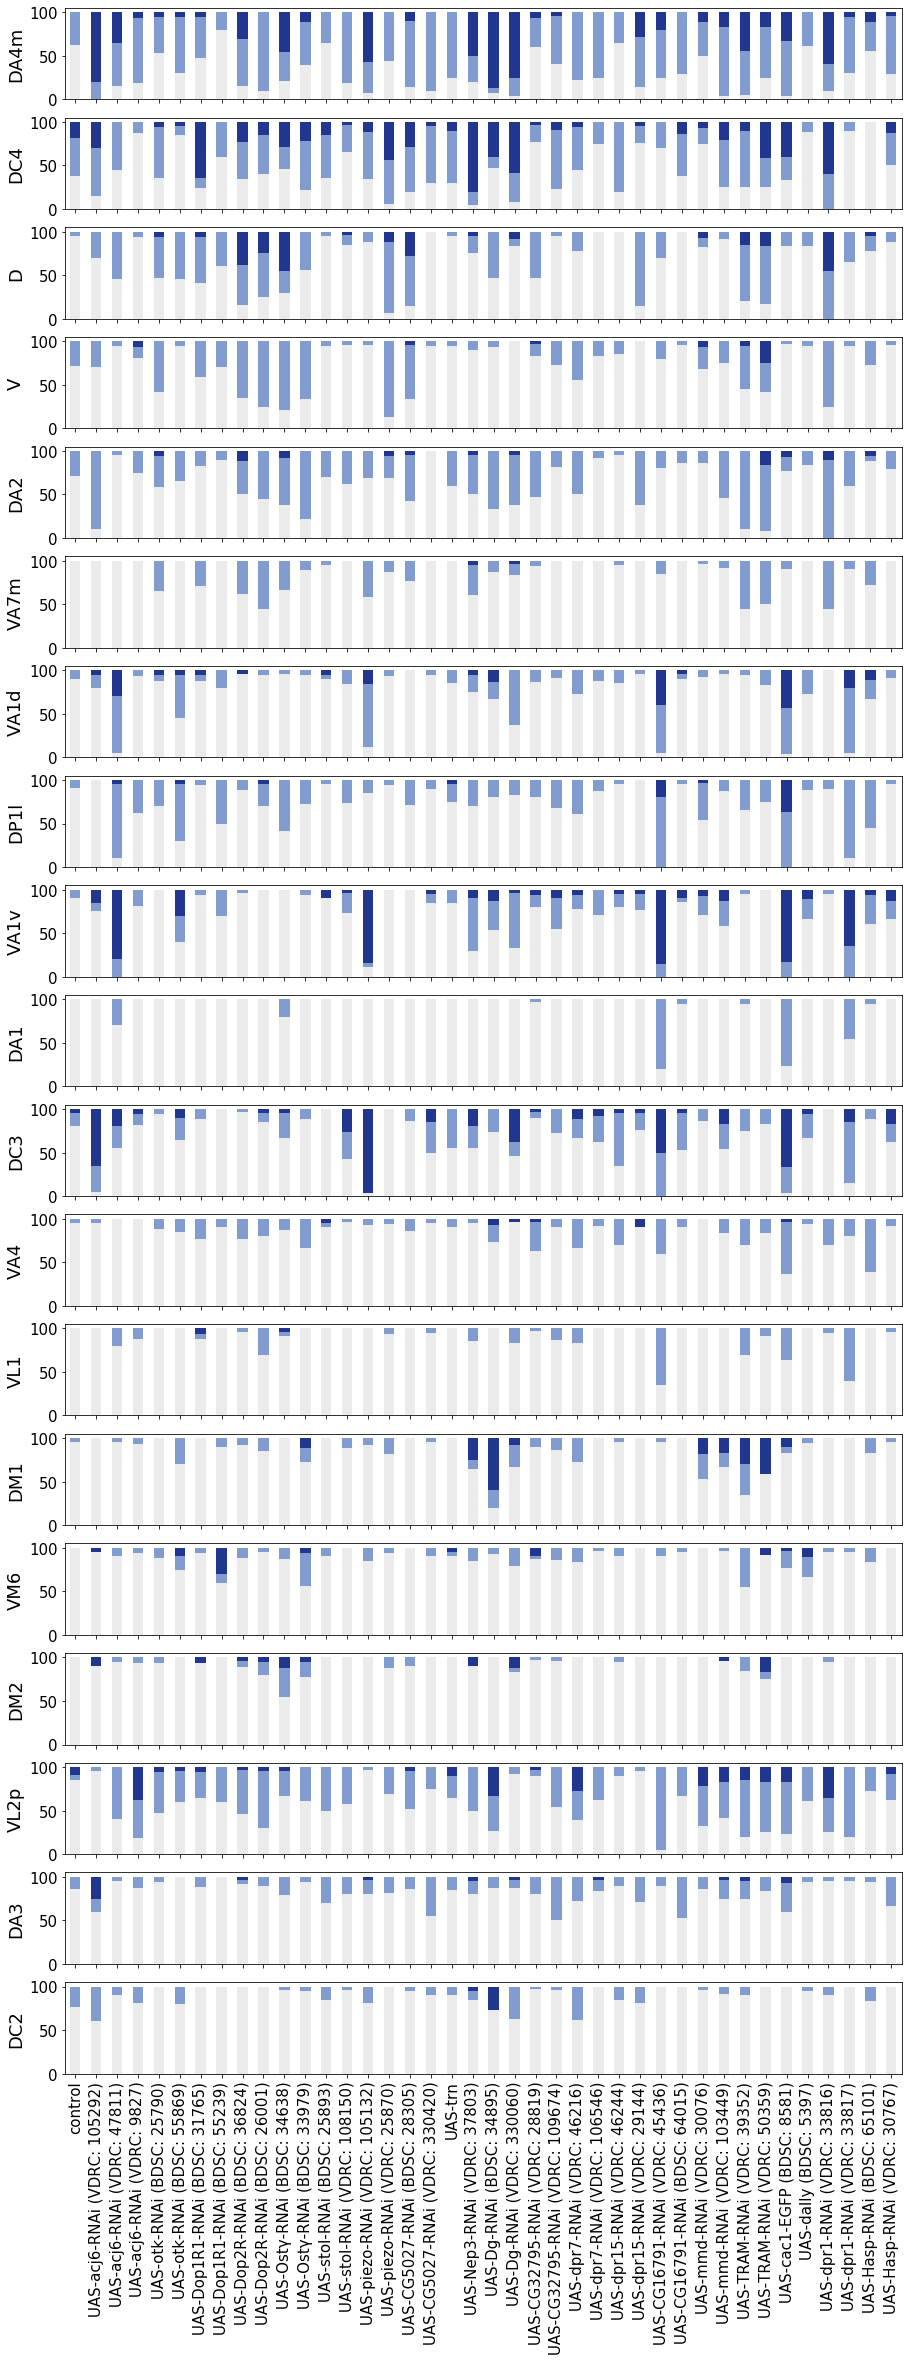

In [47]:
fig, axes = plot_bars(pd_freq, glo_order[:19])
fig.savefig('../figure/stacked_bar/gene_name_first19.pdf', bbox_inches='tight')

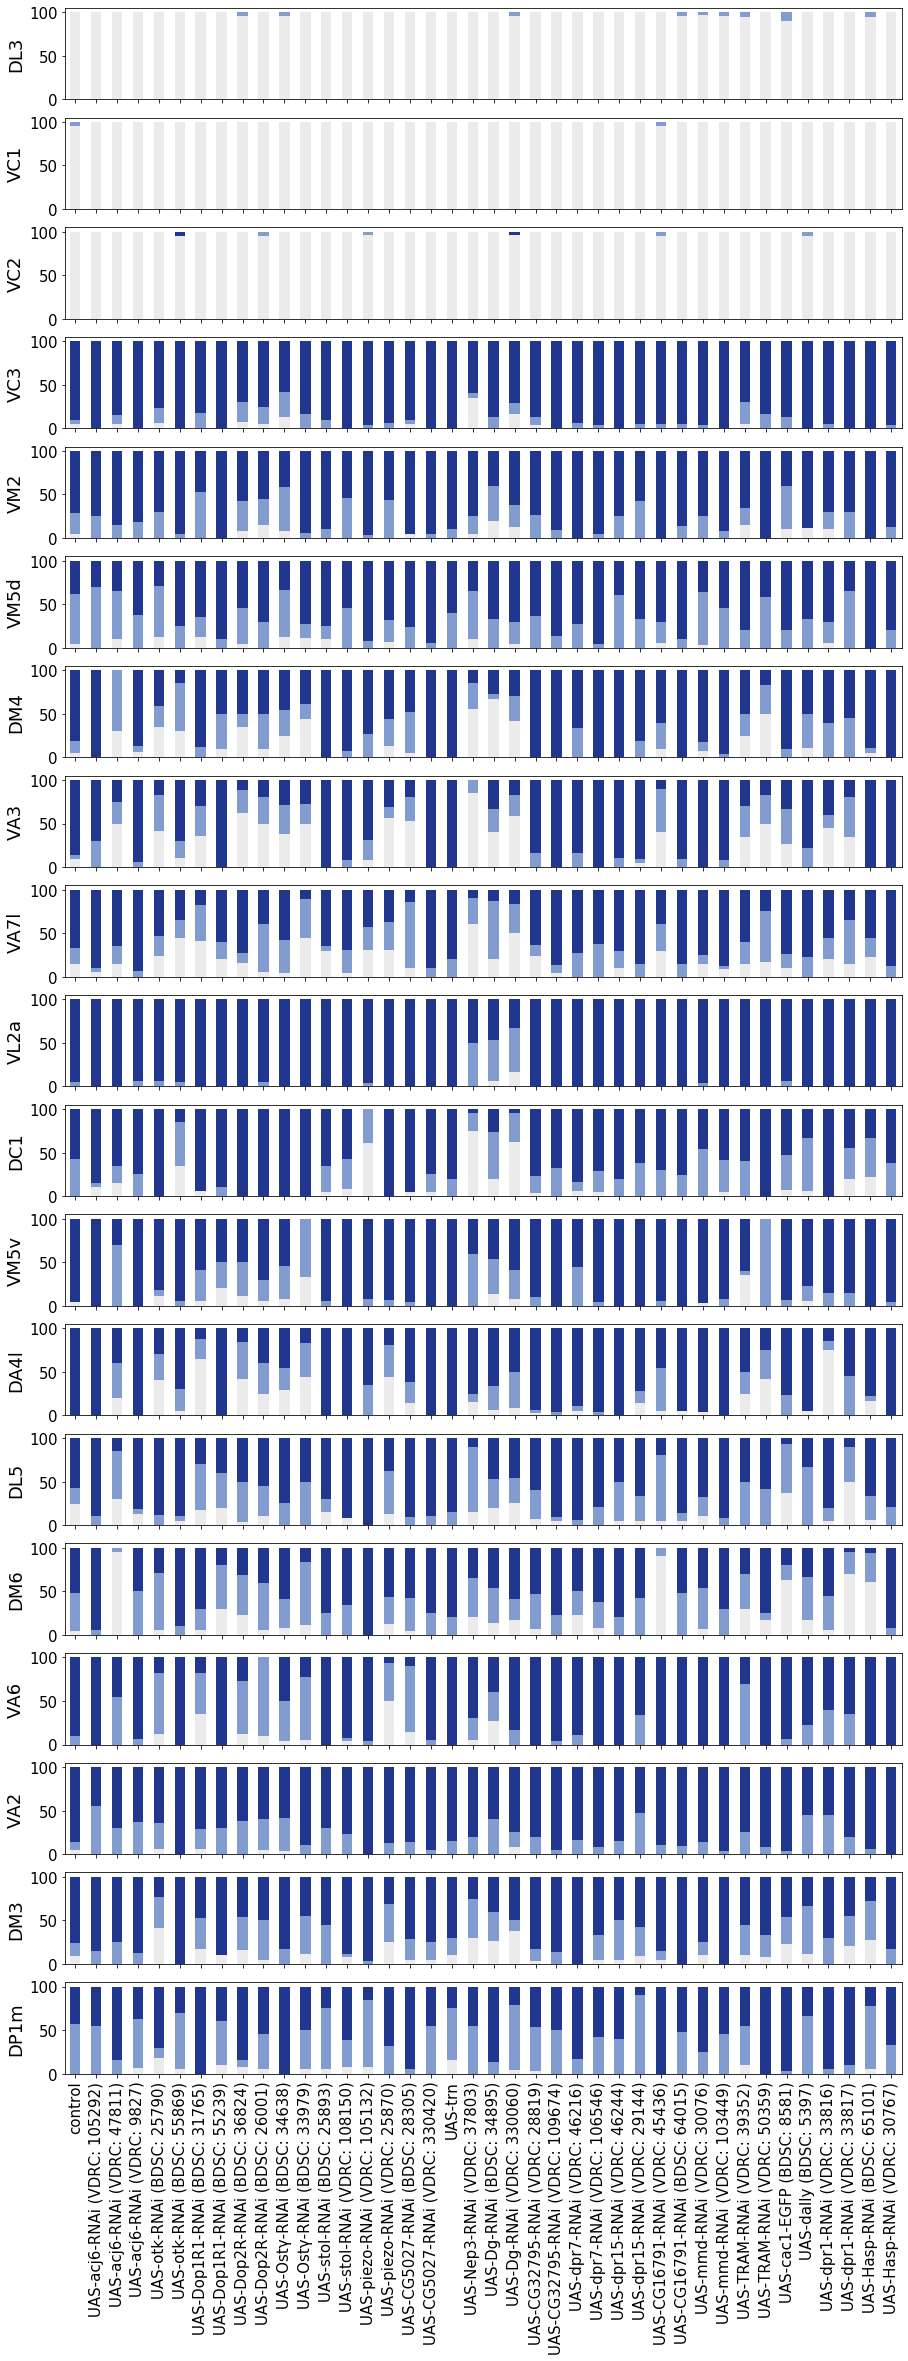

In [48]:
fig, axes = plot_bars(pd_freq, glo_order[19:])
fig.savefig('../figure/stacked_bar/gene_name_last19.pdf', bbox_inches='tight')